In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, LeakyReLU, MaxPooling2D, BatchNormalization, Reshape, Dropout
from tensorflow.keras.losses import binary_crossentropy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
monets = glob.glob('/content/drive/MyDrive/Colab Notebooks/KaggleArtCompetition/gan-getting-started/monet_jpg/*')
monets = np.array([imread(i) for i in monets])
photos = glob.glob('/content/drive/MyDrive/Colab Notebooks/KaggleArtCompetition/gan-getting-started/photo_jpg/*')
photos = np.array([imread(i) for i in photos[:300]])

In [6]:
monets = (monets/127.5)-1
photos = (photos/127.5)-1

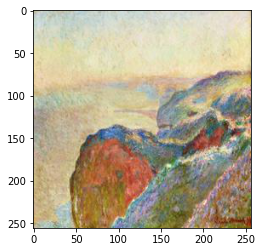

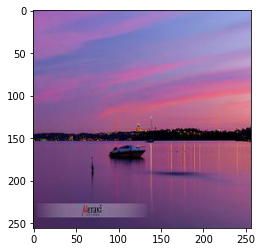

In [7]:
sample_monet = monets[0]
plt.figure()
plt.imshow(monets[0]*.5 + .5)
sample_photo = photos[0]
plt.figure()
plt.imshow(sample_photo*.5 + .5)

sample_monet = np.expand_dims(sample_monet, 0)
sample_photo = np.expand_dims(sample_photo, 0)

## Discriminator

In [8]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [9]:
from tensorflow_addons.layers import InstanceNormalization

def make_downsample_layer(filters, size, instancenorm=True):
  init = tf.initializers.random_normal(mean=0, stddev=0.02)
  submodel = Sequential([
                         Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False)
  ])
  if instancenorm:
    submodel.add(InstanceNormalization())

  submodel.add(LeakyReLU())
  return submodel

In [10]:
def make_upsample_layer(filters, size, apply_dropout=False):
  init = tf.initializers.random_normal(0.0, 0.02)

  submodel = tf.keras.models.Sequential([Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False, kernel_initializer=init)])

  if apply_dropout:
    submodel.add(Dropout(.5))

  submodel.add(LeakyReLU())
  return submodel

## Generator

In [11]:
def generator():
  inputs = tf.keras.layers.Input(shape=[None, None, 3])

  down = [
          # for each layer in down, the added dimension is filters, the image size dimensions are halved because of strides=2, filter size = 4
          make_downsample_layer(64, 4, instancenorm=False), # (batch_size, 128, 128, 64)
          make_downsample_layer(128, 4), # (batch_size, 64, 64, 128)
          make_downsample_layer(256, 4), # (batch_size, 32, 32, 256)
          make_downsample_layer(512, 4), # 16
          make_downsample_layer(512, 4), # 8
          make_downsample_layer(512, 4), # 4
          make_downsample_layer(512, 4), # 2
          make_downsample_layer(512, 4), # 1
  ]
  # we need our up and downs to have layers of the same size so we can make skip connections between them
  # also, when we upsample, we have to inform our layer what kernel size we downsampled with
  up = [
        make_upsample_layer(512, 4, apply_dropout=True), # 2
        make_upsample_layer(512, 4, apply_dropout=True), # 4
        make_upsample_layer(512, 4, apply_dropout=True), # 8
        make_upsample_layer(512, 4), # 16
        make_upsample_layer(256, 4), # 32
        make_upsample_layer(128, 4), # 64
        make_upsample_layer(64, 4), # 128
  ]

  init = tf.random_normal_initializer(stddev=.02)
  # There should be 3 output channels for RGB
  final_layer = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation = 'tanh', kernel_initializer=init) 
  # finally back to (batch_size, 256, 256, 3)

  # Lets now create a tensor x and send it through the entire model
  x = inputs
  skips = []
  for l in down:
    x = l(x)
    skips.append(x)
  
  skips = skips[:-1] # the last down has no skip connection

  for i in range(len(up)):
    x = up[i](x)
    x = tf.keras.layers.Concatenate()([x, skips[-1-i]])
  
  x = final_layer(x)
  return tf.keras.models.Model(inputs=inputs, outputs=x)

In [12]:
def discriminator():
  init = tf.random_normal_initializer(stddev=.02)
  
  inp = tf.keras.Input(shape=[256, 256, 3], name='input_image')
  # target = tf.keras.Input(shape=[256, 256, 3], name='target_image')

  down1 = make_downsample_layer(64, 4, instancenorm=False)(inp) # 128
  down2 = make_downsample_layer(128, 4)(down1) # 64
  down3 = make_downsample_layer(256, 4)(down2) # 32

  # Later I should try running without zero_padding layers
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  c = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)

  ino = InstanceNormalization()(c)
  lr = LeakyReLU()(ino)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(lr)

  c2 = Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)

  return tf.keras.Model(inp, c2)

In [13]:
OUTPUT_CHANNELS = 3
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


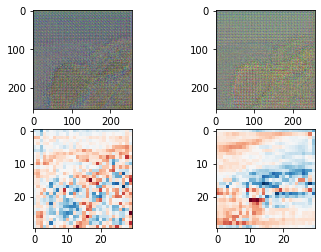

In [14]:
# test generators and discriminators
fig, axs = plt.subplots(2,2)

# We greatly increase the contrast (*8)
generated_sample_monet = monet_generator(sample_monet)
axs[0,0].imshow(generated_sample_monet[0]*4 + .5)

generated_sample_photo = photo_generator(sample_monet)
axs[0,1].imshow(generated_sample_photo[0]*4 + .5)

discriminated_monet = monet_discriminator(sample_monet)
axs[1,0].imshow(discriminated_monet[0, ..., -1], cmap='RdBu_r')

discriminated_photo = photo_discriminator(sample_photo)
axs[1,1].imshow(discriminated_photo[0, ..., -1], cmap='RdBu_r')

In [15]:
crossLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
  real_loss = crossLoss(tf.ones_like(real), real)
  fake_loss = crossLoss(tf.ones_like(fake), fake)
  return (real_loss + fake_loss)

def generator_loss(generated):
  return crossLoss(tf.ones_like(generated), generated)

def cycle_loss(image, cycled_image):
  return tf.reduce_mean(abs(image - cycled_image))*.5

def identity_loss(image, generated_same_image):
  return tf.reduce_mean(abs(image - generated_same_image))*.5

In [16]:
# Optimizers
monet_gen_optimizer = Adam(2e-4, beta_1=.5)
photo_gen_optimizer = Adam(2e-4, beta_1=.5)
monet_disc_optimizer = Adam(2e-4, beta_1=.5)
photo_disc_optimizer = Adam(2e-4, beta_1=.5)

In [17]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           monet_gen_optimizer=monet_gen_optimizer,
                           photo_gen_optimizer=photo_gen_optimizer,
                           monet_disc_optimizer=monet_disc_optimizer,
                           photo_disc_optimizer=photo_disc_optimizer)

checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [18]:
epochs = 10
def generate_images(model, input):
  prediction = model(input)
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(input[0]*.5+.5)
  axs[1].imshow(prediction[0]*.5+.5)


In [19]:
@tf.function
def train_step(monet, photo):
  with tf.GradientTape(persistent=True) as tape:

    identity_monet = monet_generator(monet, training=True)
    identity_photo = photo_generator(photo, training=True)

    fake_photo = photo_generator(monet, training=True)
    cycled_monet = monet_generator(fake_photo, training=True)

    fake_monet = monet_generator(photo, training=True)
    cycled_photo = photo_generator(fake_monet, training=True)

    discriminated_fake_photo = photo_discriminator(fake_photo, training=True)
    discriminated_fake_monet = monet_discriminator(fake_monet, training=True)
    discriminated_real_monet = monet_discriminator(monet, training=True)
    discriminated_real_photo = photo_discriminator(photo, training=True)

    monet_gen_loss = generator_loss(discriminated_fake_monet)
    photo_gen_loss = generator_loss(discriminated_fake_photo)

    total_cycle_loss = cycle_loss(monet, cycled_monet) + cycle_loss(photo, cycled_photo)
    total_identity_loss = identity_loss(monet, identity_monet) + identity_loss(photo, identity_photo)

    # Total losses for 4 models
    total_monet_gen_loss = monet_gen_loss + total_cycle_loss + total_identity_loss 
    total_photo_gen_loss = photo_gen_loss + total_cycle_loss + total_identity_loss 

    monet_disc_loss = discriminator_loss(discriminated_real_monet, discriminated_fake_monet)
    photo_disc_loss = discriminator_loss(discriminated_real_photo, discriminated_fake_photo)

    # Calculate gradients for 4 models
  monet_gen_grads = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
  photo_gen_grads = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)
  monet_disc_grads = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
  photo_disc_grads = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)

    # print(monet_gen_grads.shape, monet_generator)
  monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
  photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))
  monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
  photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))



In [20]:
import time
tf.config.run_functions_eagerly(True)

for epoch in range(epochs):
  n = 0
  start = time.time()
  for i in range(300):
    monet = monets[i:i+1, :, :, :].astype('float32')
    photo = photos[i:i+1, :, :, :].astype('float32')
    train_step(monet, photo)
    n += 1
    if n % 50 == 0:
      print('time for', n, 'steps:', time.time()-start)

  save_path = checkpoint_manager.save()
  print('Saved checkpoint at epoch:', epoch)
  
generate_images(photo_generator, sample_monet)

time for 50 steps: 91.05492067337036
time for 100 steps: 180.99208545684814
time for 150 steps: 270.30728912353516
time for 200 steps: 360.41648960113525
time for 250 steps: 450.87893509864807
time for 300 steps: 541.1635999679565
Saved checkpoint at epoch: 0
time for 50 steps: 91.22510194778442
time for 100 steps: 181.74981212615967


KeyboardInterrupt: ignored

In [21]:
if checkpoint_manager.latest_checkpoint:
  ckpt.restore(checkpoint_manager.latest_checkpoint)
  print('Checkpoint Restored')

Checkpoint Restored


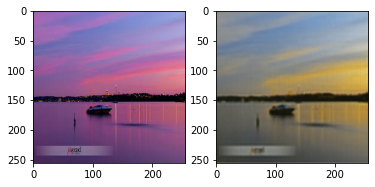

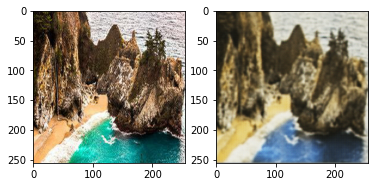

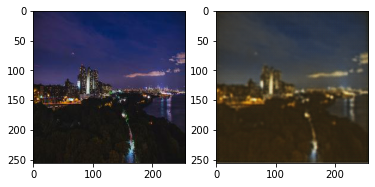

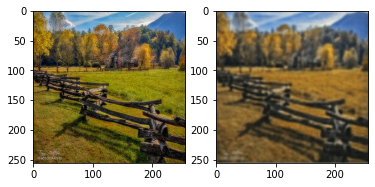

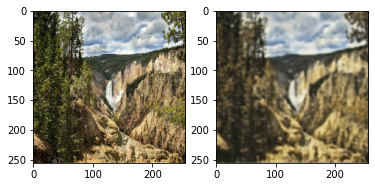

In [22]:
for pic in photos[:5, :, :, :]:
  generate_images(monet_generator, np.expand_dims(pic, 0))

In [ ]:
"""
photos = glob.glob('/content/drive/MyDrive/Colab Notebooks/KaggleArtCompetition/gan-getting-started/photo_jpg/*')
i = 0
for pic in photos:
  i +=1
  pic = imread(pic)
  pic = (pic/127.5)-1
  monet_copy = monet_generator(np.expand_dims(pic, 0))
  path = '/content/drive/MyDrive/Colab Notebooks/KaggleArtCompetition/monet_results/' + str(i)
  plt.imsave(path, monet_copy, format='jpg')
"""